In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torchvision import models
from torchvision import transforms, utils
import numpy as np
import scipy.misc
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
import json

In [2]:
def predict(image):
    _, index = vgg(image).data[0].max(0)
    return str(index[0]), labels[str(index[0])][1]
    
def deprocess(image):
    return image * torch.Tensor([0.229, 0.224, 0.225]).cuda()  + torch.Tensor([0.485, 0.456, 0.406]).cuda()

def load_image(path):
    image = Image.open(path)
    plt.imshow(image)
    plt.axis('off')
    print("Image loaded successfully")
    return image

normalise = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
    )
preprocess = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    normalise
    ])

In [3]:
def gradcam(input, label, last_conv_layer):
    rs = transforms.Resize((224,224))
    pre_image = rs(input)
    input = Variable(preprocess(input).unsqueeze(0).cuda(), requires_grad=True)
    vgg.zero_grad()
    for i, layer in enumerate(modulelist_conv[1:]):
        input = layer(input)
        if i==last_conv_layer:
            input.retain_grad()
            last_conv = input
    input = input.view(input.size()[0], -1)
    for i, layer in enumerate(modulelist_fc[1:]):
        input = layer(input)
    input[0][label].backward()
    
    grads = last_conv.grad.data.sum(3).squeeze()
    grads = grads.sum(1)
    grads = torch.Tensor([[[i]] for i in grads])
    grads = grads.cuda()
    data = last_conv.data.squeeze()
    a = torch.mul(data, grads)
    a = a.sum(0)
    a = a.clamp(min=0)
    a = Image.fromarray(a.cpu().numpy())
    a = rs(a)
    a = np.array(a)
    a -= a.min()
    a /= a.max()
    a *= 255
    plt.rcParams["figure.figsize"] = (10,10)
    plt.subplot(1,3,1)
    plt.imshow(pre_image)
    plt.axis('off')
    plt.subplot(1,3,2)
    plt.axis('off')
    plt.imshow(a, cmap='afmhot')
    plt.subplot(1,3,3)
    plt.imshow(pre_image)
    plt.imshow(a, cmap='afmhot', alpha=0.6)
    plt.axis('off')
    return a

In [4]:
vgg = models.vgg16(pretrained=True)
vgg = vgg.cuda()

In [5]:
labels = json.load(open('labels/imagenet_class_index.json'))

In [6]:
modulelist_conv = list(vgg.features.modules())
modulelist_fc = list(vgg.classifier.modules())

Image loaded successfully


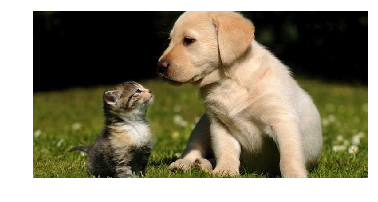

In [7]:
dc = load_image("./images/dogcat2.jpg")

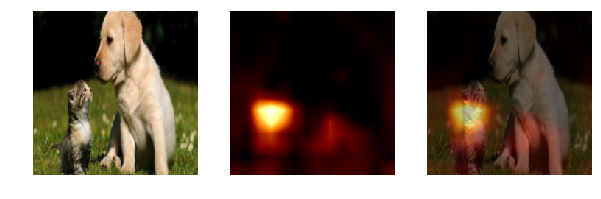

In [8]:
mask = gradcam(dc, 281, 29)

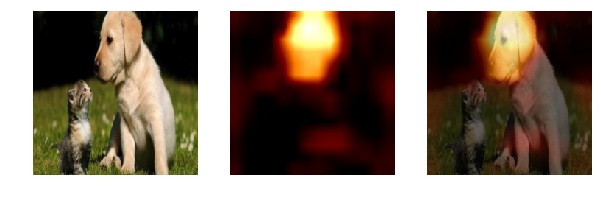

In [9]:
mask = gradcam(dc, 207, 29)